# Analysis of ProB backend over the 109 features set

In this note book we will explore the ProB native backend with default settings over the F109 feature set by employing decision trees and random forests.

In [1]:
%run f109_info.py

import pandas as pd
import numpy as np

data = pd.read_csv('data/2020-01-17/prob-f109_unique.csv')
n_features = 109

data.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature100,Feature101,Feature102,Feature103,Feature104,Feature105,Feature106,Feature107,Feature108,Label0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Data insights

Firstly, we check how many positive and negative samples exist in the data.

In [2]:
sample_count = len(data)
positive = data[data["Label0"] == 1]
negative = data[data["Label0"] == 0]

print("We have %d samples in the dataset." % sample_count)
print("For %d of these, ProB is able to find a solution (%0.3f%%)" % (len(positive), len(positive)/sample_count))
print("For %d of these, ProB is _not_ able to find a solution (%0.3f%%)" % (len(negative), len(negative)/sample_count))

We have 105742 samples in the dataset.
For 95306 of these, ProB is able to find a solution (0.901%)
For 10436 of these, ProB is _not_ able to find a solution (0.099%)


Text(0, 0.5, '# Samples')

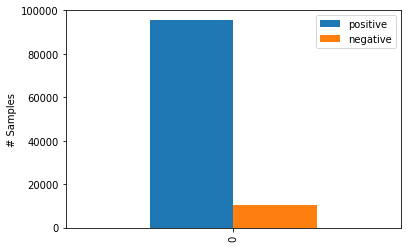

In [3]:
%matplotlib inline

class_balance = pd.DataFrame(data={"positive": [len(positive)], "negative": [len(negative)]})
class_balance_plot = class_balance.plot(kind="bar")
class_balance_plot.set_ylabel("# Samples")

Now we will inspect how often each feature is used in the data in the first place. Thus we can evaluate how much significance each evaluation over the subdomains has.

In [116]:
feature_uses = data[data > 0].count() 
rel_feature_uses = feature_uses/sample_count

fd = {}
for f in range(n_features):
    fd["Feature%d" % f] = [feature_uses[f]]
feature_data = pd.DataFrame(data=fd)
feature_data

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature99,Feature100,Feature101,Feature102,Feature103,Feature104,Feature105,Feature106,Feature107,Feature108
0,64527,89513,87662,87662,87662,105661,75881,74875,86585,16625,...,27,878,204,0,142,8,2,0,551,22


In [117]:
# We also calculate the relative amount of feature uses.
fd = {}
for f in range(n_features):
    fd["Feature%d" % f] = [rel_feature_uses[f]]
rel_feature_data = pd.DataFrame(data=fd)
rel_feature_data

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature99,Feature100,Feature101,Feature102,Feature103,Feature104,Feature105,Feature106,Feature107,Feature108
0,0.610231,0.846523,0.829018,0.829018,0.829018,0.999234,0.717605,0.708091,0.818833,0.157222,...,0.000255,0.008303,0.001929,0.0,0.001343,0.000076,0.000019,0.0,0.005211,0.000208


In [118]:
mean_diffs = data.groupby("Label0").mean()
mean_diffs

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature99,Feature100,Feature101,Feature102,Feature103,Feature104,Feature105,Feature106,Feature107,Feature108
Label0,,,,,,,,,,,,,,,,,,,,,
0.0,1.745975,2.681329,0.355831,0.302545,0.578898,31.363969,0.017901,0.767838,0.204809,0.009355,...,0.001342,0.004791,0.003234,0.0,0.001246,0.000000,0.000000,0.0,0.003173,0.000623
1.0,2.056623,2.724795,0.486687,0.378397,0.706723,10.644261,-0.407075,1.034834,0.354419,0.016982,...,0.000094,0.008478,0.001715,0.0,0.001354,0.000084,0.000021,0.0,0.003262,0.000089


Let us list the sorted differences in mean by feature.

In [119]:
sorted_mean_diffs = ((mean_diffs.iloc[0] / mean_diffs.iloc[1])).sort_values(ascending=False)

for k in sorted_mean_diffs.keys():
    fid = int(k[7:])
    print(f109_name(fid), sorted_mean_diffs[k])

`reverse` calls ratio per seq op 14.20599577373467
`tail` calls ratio per seq op 10.197877301966798
number of iterations per conjunct 6.983620048249273
Set operations per conjunct 6.847720619492528
Lambda-expression ratio over functions 4.689601527065064
Surjective, partial function ratio over functions 4.031505759312617
Function applications per conjunct 3.8334226375539022
Relational overrides ratio of rel ops 3.5445926807245445
Equality per conjunct 3.3718832923977846
Quantified set unions per set set op 3.268976515201772
Injective, total function ratio over functions 3.1722049301873505
Arithmetic ops per conjunct 3.1573470423425105
Powersets per conjunct 2.972444125118314
Logic ops per conjunct 2.9465615190874583
Functions per conjunct 2.920117195654786
Set inclusions per conjunct 2.7437529229808995
Quantifiers per conjunct 2.6028791185703795
Rel ops per conjunct 2.51927728119089
Number of identifiers per conjunct 2.380184164384825
Inequality per conjunct 2.175467409840458
Parallel 

## Training a Classifier

First, let's check the performance a decision tree or a random forest can reach on a designated train and test set.

### Prepare the training and test data

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.2)
train_x = train[train.columns[0:n_features]]
train_y = train["Label0"]

test_x = test[test.columns[0:n_features]]
test_y = test["Label0"]

In [8]:
%run printing.py

<Figure size 432x288 with 0 Axes>

### Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(class_weight="balanced")

tree.fit(train_x, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [10]:
print_classifier_stats(tree, test_x, test_y)

Test accuracy: 0.916
Test balanced accuracy: 0.758
Test precision: 0.949
Test recall: 0.958
Test F1: 0.954


### Random Forest and Gini Importance

Next we will train a random forest with Gini Impurity and also calculate the respective gini importances of each feature.

In [11]:
from sklearn.ensemble import RandomForestClassifier

forest_0 = RandomForestClassifier(
    n_estimators=100, # 100 Trees.
    criterion="gini", # Using Gini index instead of "entropy"
    n_jobs=6, # Number of CPUs to use.
    bootstrap=False,
    max_features=0.7,
    random_state=124,
    class_weight="balanced")

forest_0.fit(train_x, train_y)


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
                       oob_score=False, random_state=124, verbose=0,
                       warm_start=False)

In [12]:
print_classifier_stats(forest_0, test_x, test_y)


Test accuracy: 0.932
Test balanced accuracy: 0.809
Test precision: 0.967
Test recall: 0.959
Test F1: 0.963


## Training on the full data set

For the feature evaluation it might be more of interest to not exclude the test set from the training data. We do not aim for a good predictor but instead for an analysis over the whole dataset.

In [13]:
X = data[data.columns[0:n_features]]
Y = data["Label0"]

forest = RandomForestClassifier(
    n_estimators=100, # 100 Trees.
    criterion="gini", # Using Gini index instead of "entropy"
    n_jobs=6, # Number of CPUs to use.
    bootstrap=False,
    max_features=0.7,
    random_state=123,
    class_weight="balanced")

forest.fit(X, Y)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [14]:
# metrics and classification matrix here

List features by importance

In [15]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [17]:
# Print the feature ranking
print("Feature ranking:")

cat_count_top50 = {}
cat_count_top100 = {}
for f in range(100):
    cat = f109_category(indices[f])
    cat_count_top100[cat] = cat_count_top100.get(cat, 0) + 1
    if f < 50:
        cat_count_top50[cat] = cat_count_top50.get(cat, 0) + 1
    print("%3d. feature %3d (importance: %1.6f, rel. usage: %1.6f):  [%-11s]  %s" % (f + 1, indices[f], importances[indices[f]], rel_feature_uses[indices[f]], cat, f109_name(indices[f])))

Feature ranking:
  1. feature  80 (importance: 0.126166, rel. usage: 0.540845):  [Functions  ]  Function applications per conjunct
  2. feature  23 (importance: 0.051904, rel. usage: 0.537535):  [Identifiers]  Function var ratio of identifiers
  3. feature   6 (importance: 0.036477, rel. usage: 0.717605):  [Logic      ]  Conjunctions per logic ops
  4. feature   2 (importance: 0.036075, rel. usage: 0.829018):  [Logic      ]  number of negations per conjunct
  5. feature  44 (importance: 0.033492, rel. usage: 0.861758):  [Set theory ]  Set memberships per set inclusion op
  6. feature  31 (importance: 0.031042, rel. usage: 0.486779):  [Arithmetic ]  Arithmetic ops per conjunct
  7. feature  16 (importance: 0.028246, rel. usage: 0.792353):  [Equality   ]  Equality per conjunct
  8. feature   8 (importance: 0.027742, rel. usage: 0.818833):  [Logic      ]  Implications per logic ops
  9. feature  32 (importance: 0.027564, rel. usage: 0.192317):  [Arithmetic ]  Addition ratio of arithmetic 

How many of the features of each category made it to the top 100?

In [20]:
cat_count_total = {}
for f in range(n_features):
    cat = f109_category(f)
    cat_count_total[cat] = cat_count_total.get(cat, 0) + 1

### Category count in Top 100

In [21]:
for cat, count in cat_count_total.items():
    top100 = cat_count_top100.get(cat, 0)
    print("%-11s: %2d/%2d, %.3f%%" % (cat, top100, count, top100/count))

Logic      : 11/11, 1.000%
Quantifiers:  4/ 4, 1.000%
Equality   :  2/ 2, 1.000%
Identifiers: 13/13, 1.000%
Arithmetic : 10/10, 1.000%
Set theory : 17/18, 0.944%
Relations  : 20/20, 1.000%
Functions  : 11/11, 1.000%
Sequences  : 10/17, 0.588%
Closure    :  2/ 3, 0.667%


### Category count in Top 50

In [22]:
for cat, count in cat_count_total.items():
    top50 = cat_count_top50.get(cat, 0)
    print("%-11s: %2d/%2d, %.3f%%" % (cat, top50, count, top50/count))

Logic      : 10/11, 0.909%
Quantifiers:  3/ 4, 0.750%
Equality   :  2/ 2, 1.000%
Identifiers: 12/13, 0.923%
Arithmetic :  4/10, 0.400%
Set theory : 10/18, 0.556%
Relations  :  4/20, 0.200%
Functions  :  4/11, 0.364%
Sequences  :  1/17, 0.059%
Closure    :  0/ 3, 0.000%


### Category counts Top 50 vs. Top 100

In [23]:
print("------------ %-5s %-5s Decline" % ("T100", "T50"))
for cat, count in cat_count_total.items():
    top50 = cat_count_top50.get(cat, 0)
    top100 = cat_count_top100.get(cat, 0)
    print("%-11s: %.3f %.3f %.3f" % (cat, top100/count, top50/count, ((top100-top50)/top100) if top100>0 else 0))


------------ T100  T50   Decline
Logic      : 1.000 0.909 0.091
Quantifiers: 1.000 0.750 0.250
Equality   : 1.000 1.000 0.000
Identifiers: 1.000 0.923 0.077
Arithmetic : 1.000 0.400 0.600
Set theory : 0.944 0.556 0.412
Relations  : 1.000 0.200 0.800
Functions  : 1.000 0.364 0.636
Sequences  : 0.588 0.059 0.900
Closure    : 0.667 0.000 1.000


## Taking a look at permutation importance

While the Gini index captures the average gain of splitting on each feature in their respective position in the tree, the permutation importance is more robust against variable codependencies.

In [24]:
from sklearn.inspection import permutation_importance

perm_importances = permutation_importance(forest, X, Y, scoring='balanced_accuracy', n_repeats=5, n_jobs=1, random_state=1234)
perm_indices = perm_importances.importances_mean.argsort()[::-1]

In [26]:
# Print the feature ranking
print("Feature ranking:")

pcat_count_top50 = {}
pcat_count_top100 = {}
for f in range(100):
    cat = f109_category(perm_indices[f])
    pcat_count_top100[cat] = pcat_count_top100.get(cat, 0) + 1
    if f < 50:
        pcat_count_top50[cat] = pcat_count_top50.get(cat, 0) + 1
    print("%3d. feature %3d (importance: %1.6f, rel. usage: %1.6f):  [%-11s]  %s" % (f + 1, perm_indices[f], perm_importances.importances_mean[perm_indices[f]], rel_feature_uses[perm_indices[f]], cat, f109_name(perm_indices[f])))

Feature ranking:
  1. feature  80 (importance: 0.261836, rel. usage: 0.540845):  [Functions  ]  Function applications per conjunct
  2. feature   2 (importance: 0.132841, rel. usage: 0.829018):  [Logic      ]  number of negations per conjunct
  3. feature  16 (importance: 0.091192, rel. usage: 0.792353):  [Equality   ]  Equality per conjunct
  4. feature   6 (importance: 0.085579, rel. usage: 0.717605):  [Logic      ]  Conjunctions per logic ops
  5. feature  18 (importance: 0.082324, rel. usage: 0.999385):  [Identifiers]  Number of identifiers per conjunct
  6. feature  23 (importance: 0.065690, rel. usage: 0.537535):  [Identifiers]  Function var ratio of identifiers
  7. feature   8 (importance: 0.064990, rel. usage: 0.818833):  [Logic      ]  Implications per logic ops
  8. feature  44 (importance: 0.053351, rel. usage: 0.861758):  [Set theory ]  Set memberships per set inclusion op
  9. feature  32 (importance: 0.044281, rel. usage: 0.192317):  [Arithmetic ]  Addition ratio of arit

In [27]:
print("------------ %-5s %-5s Decline" % ("T100", "T50"))
for cat, count in cat_count_total.items():
    top50 = pcat_count_top50.get(cat, 0)
    top100 = pcat_count_top100.get(cat, 0)
    print("%-11s: %.3f %.3f %.3f" % (cat, top100/count, top50/count, ((top100-top50)/top100) if top100>0 else 0))


------------ T100  T50   Decline
Logic      : 1.000 0.909 0.091
Quantifiers: 1.000 0.750 0.250
Equality   : 1.000 1.000 0.000
Identifiers: 1.000 0.846 0.154
Arithmetic : 0.900 0.400 0.556
Set theory : 0.778 0.500 0.357
Relations  : 0.850 0.300 0.647
Functions  : 1.000 0.364 0.636
Sequences  : 1.000 0.059 0.941
Closure    : 0.667 0.000 1.000


## Top 50/100 comparison between Gini Importance and Permutation Importance

In [28]:
print(".             Gini         Permutation")
print(".             %-5s %-5s  %-5s %-5s" % ("T100", "T50", "T100", "T50"))
for cat, count in cat_count_total.items():
    top50 = cat_count_top50.get(cat, 0)
    top100 = cat_count_top100.get(cat, 0)
    ptop50 = pcat_count_top50.get(cat, 0)
    ptop100 = pcat_count_top100.get(cat, 0)
    print("%-11s:  %.3f %.3f  %.3f %.3f" % (cat, top100/count, top50/count, ptop100/count, ptop50/count))


.             Gini         Permutation
.             T100  T50    T100  T50  
Logic      :  1.000 0.909  1.000 0.909
Quantifiers:  1.000 0.750  1.000 0.750
Equality   :  1.000 1.000  1.000 1.000
Identifiers:  1.000 0.923  1.000 0.846
Arithmetic :  1.000 0.400  0.900 0.400
Set theory :  0.944 0.556  0.778 0.500
Relations  :  1.000 0.200  0.850 0.300
Functions  :  1.000 0.364  1.000 0.364
Sequences  :  0.588 0.059  1.000 0.059
Closure    :  0.667 0.000  0.667 0.000


## Taking a look at the individual decision trees

In [37]:
%run feature_stats.py

def calc_feature_stats(feature_ids):
    """Returns a dictionary over the given feature ids as keys.
    For each feature, another dictionary with the following structure is returned:
        {'rank-gini': rank_gini_importance, 'rank-permutation': rank_permutation_importance,
         'tendency': tendency,
         'thresholds': {'list': thresholds,
                        'avg': avg_threshold,
                        'median': median_threshold},
         'num_lower_below_threshold': num_left_lower,
         'num_lower_above_threshold': num_right_lower}
    The entry might be an empty dictionary if the corresponding feature was not used.
    """
    stats = {}
    for fid in feature_ids:
        rank_gini = np.argwhere(indices == fid)[0][0]+1
        rank_perm = np.argwhere(perm_indices == fid)[0][0]+1
        thresholds = []
        num_left_lower = 0
        num_right_lower = 0
        for tinfo in ftree_infos:
            split_info = tinfo['splits'][fid]
            if split_info == {}: continue # Feature not used in this tree.
            thresholds.append(split_info['threshold'])
            if split_info['unknown_rate'] > split_info['unknown_rate_left']:
                num_left_lower += 1
            else:
                num_right_lower += 1
        thresholds.sort()
        if (len(thresholds) == 0):
            stats[fid] = {}
            continue
        avg_threshold = sum(thresholds)/len(ftree_infos)
        med_threshold = thresholds[len(thresholds)//2]
        tendency = num_right_lower - num_left_lower
        stats[fid] = {'rank-gini': rank_gini, 'rank-permutation': rank_perm,
                      'tendency': tendency, 'thresholds': {'list': thresholds, 'avg': avg_threshold, 'median': med_threshold},
                      'num_lower_below_threshold': num_left_lower, 'num_lower_above_threshold': num_right_lower}
    return stats


def print_feature_stats(feature_stats):
    for fid in sorted(feature_stats.keys()):
        stats = feature_stats.get(fid)
        if stats == {}:
            print(f109_name(fid))
            print("  feature is not used.")
            continue
        print(f109_name(fid))
        print("  - Gini rank no.", stats['rank-gini'], "  Perm. rank no.", stats['rank-permutation'], "-")
        print("  avg threshold: %.3f (min %.3f, max %.3f, median %.3f)" % (stats['thresholds']['avg'], stats['thresholds']['list'][0], stats['thresholds']['list'][-1], stats['thresholds']['median']))
        tendency = stats['tendency']
        num_left_lower = stats['num_lower_below_threshold']
        num_right_lower = stats['num_lower_above_threshold']
        print("  %.2f%% of trees observe higher solvability if below threshold, %.2f%% above" % (100*num_left_lower/len(ftree_infos), 100*num_right_lower/len(ftree_infos)))
        print("  tendency of %s values for more solvable constraints (tendency value: %d)" % ("higher" if tendency > 0 else "lower", tendency))


def print_feature_group_stats(features, category_name):
    print("#", category_name)
    fs = calc_feature_stats(features)
    tendencies = [fs[s]['tendency'] for s in fs.keys() if fs[s] != {}]
    print("  Average tendency:", sum(tendencies)/len(tendencies))
    print_feature_stats(fs)



In [30]:
forest_trees = forest.estimators_

ftree_infos = []

for tree in forest_trees:
    ftree_infos.append(gather_tree_info(tree))

For the top 50 features, what are the thresholds and where do they lead?
The tendency values range from -100 to 100 (including) and show how many trees in the forest lead to an answer if the value is below (-100) or above (+100) their respective threshold.

In [32]:
for fid in indices[0:50]:
    print("->", f109_name(fid))
    thresholds = []
    num_left_lower = 0
    num_right_lower = 0
    for tinfo in ftree_infos:
        split_info = tinfo['splits'][fid]
        if split_info == {}: continue # Feature not used in this tree.
        thresholds.append(split_info['threshold'])
        if split_info['unknown_rate'] > split_info['unknown_rate_left']:
            num_left_lower += 1
        else:
            num_right_lower += 1
    thresholds.sort()
    avg_threshold = sum(thresholds)/len(ftree_infos)
    med_threshold = thresholds[len(ftree_infos)//2]
    print("  avg threshold: %.3f (min %.3f, max %.3f, median %.3f)" % (avg_threshold, thresholds[0], thresholds[-1], med_threshold))
    print("  %.2f%% of trees observe higher solvability if below threshold, %.2f%% above" % (100*num_left_lower/len(ftree_infos), 100*num_right_lower/len(ftree_infos)))
    tendency = num_right_lower - num_left_lower
    print("  tendency of %s values for more solvable constraints (tendency value: %d)" % ("higher" if tendency > 0 else "lower", tendency))


-> Function applications per conjunct
  avg threshold: 0.438 (min 0.020, max 3.500, median 0.447)
  90.00% of trees observe higher solvability if below threshold, 10.00% above
  tendency of lower values for more solvable constraints (tendency value: -80)
-> Function var ratio of identifiers
  avg threshold: 0.103 (min 0.011, max 0.294, median 0.081)
  64.00% of trees observe higher solvability if below threshold, 36.00% above
  tendency of lower values for more solvable constraints (tendency value: -28)
-> Conjunctions per logic ops
  avg threshold: 0.140 (min -30.500, max 1.000, median 0.583)
  52.00% of trees observe higher solvability if below threshold, 48.00% above
  tendency of lower values for more solvable constraints (tendency value: -4)
-> number of negations per conjunct
  avg threshold: 1.219 (min 0.020, max 3.500, median 0.833)
  66.00% of trees observe higher solvability if below threshold, 34.00% above
  tendency of lower values for more solvable constraints (tendency va

We see that certain features, while having high relevancy for classification, display a tendency around 0. 
But what does that mean regarding their relevancy? Naively it look as the feature is not a language-subset in which the backend performs worse but rather that unknown-results are related to the rest of the predicate. Depending on the random data subset the respective tree was trained on, the threshold might split into better or worse samples.

### Display of tendencies per category

In [46]:
print_feature_group_stats(range(12), "Logic")

# Logic
  Average tendency: -9.333333333333334
Number of conjuncts (log2)
  - Gini rank no. 43   Perm. rank no. 78 -
  avg threshold: 2.455 (min 0.500, max 8.096, median 1.792)
  71.00% of trees observe higher solvability if below threshold, 29.00% above
  tendency of lower values for more solvable constraints (tendency value: -42)
Max conjunct depth per conjunct
  - Gini rank no. 23   Perm. rank no. 33 -
  avg threshold: 2.158 (min 0.500, max 5.949, median 1.817)
  56.00% of trees observe higher solvability if below threshold, 44.00% above
  tendency of lower values for more solvable constraints (tendency value: -12)
number of negations per conjunct
  - Gini rank no. 4   Perm. rank no. 2 -
  avg threshold: 1.219 (min 0.020, max 3.500, median 0.833)
  66.00% of trees observe higher solvability if below threshold, 34.00% above
  tendency of lower values for more solvable constraints (tendency value: -32)
max negation depth per conjunct
  - Gini rank no. 18   Perm. rank no. 37 -
  avg th

In [47]:
print_feature_group_stats(range(12, 16), "Quantifiers") 

# Quantifiers
  Average tendency: -9.5
Quantifiers per conjunct
  - Gini rank no. 29   Perm. rank no. 45 -
  avg threshold: 0.567 (min 0.004, max 3.500, median 0.408)
  59.00% of trees observe higher solvability if below threshold, 41.00% above
  tendency of lower values for more solvable constraints (tendency value: -18)
\forall ratio of all quantifiers
  - Gini rank no. 28   Perm. rank no. 24 -
  avg threshold: 0.523 (min 0.100, max 1.000, median 0.500)
  33.00% of trees observe higher solvability if below threshold, 67.00% above
  tendency of higher values for more solvable constraints (tendency value: 34)
\exists ratio of all quantifiers
  - Gini rank no. 41   Perm. rank no. 38 -
  avg threshold: 0.620 (min 0.125, max 1.000, median 0.500)
  71.00% of trees observe higher solvability if below threshold, 29.00% above
  tendency of lower values for more solvable constraints (tendency value: -42)
average nesting depth of quantifiers
  - Gini rank no. 31   Perm. rank no. 16 -
  avg thre

In [48]:
print_feature_group_stats(range(16, 18), "Equality") 

# Equality
  Average tendency: 30.0
Equality per conjunct
  - Gini rank no. 7   Perm. rank no. 3 -
  avg threshold: 2.798 (min 0.010, max 45.500, median 0.500)
  38.00% of trees observe higher solvability if below threshold, 62.00% above
  tendency of higher values for more solvable constraints (tendency value: 24)
Inequality per conjunct
  - Gini rank no. 19   Perm. rank no. 19 -
  avg threshold: 0.817 (min 0.100, max 2.500, median 0.583)
  32.00% of trees observe higher solvability if below threshold, 68.00% above
  tendency of higher values for more solvable constraints (tendency value: 36)


In [49]:
print_feature_group_stats(range(18, 31), "Identifiers") 

# Identifiers
  Average tendency: -1.5384615384615385
Number of identifiers per conjunct
  - Gini rank no. 10   Perm. rank no. 5 -
  avg threshold: 3.262 (min 0.167, max 23.000, median 2.500)
  27.00% of trees observe higher solvability if below threshold, 73.00% above
  tendency of higher values for more solvable constraints (tendency value: 46)
Integer var ratio of identifiers
  - Gini rank no. 20   Perm. rank no. 15 -
  avg threshold: 0.480 (min 0.045, max 1.000, median 0.450)
  48.00% of trees observe higher solvability if below threshold, 52.00% above
  tendency of higher values for more solvable constraints (tendency value: 4)
Boolean var ratio of identifiers
  - Gini rank no. 39   Perm. rank no. 32 -
  avg threshold: 0.141 (min 0.009, max 0.500, median 0.089)
  40.00% of trees observe higher solvability if below threshold, 60.00% above
  tendency of higher values for more solvable constraints (tendency value: 20)
Set var ratio of identifiers
  - Gini rank no. 11   Perm. rank no.

In [50]:
print_feature_group_stats(range(31, 41), "Arithmetic") 

# Arithmetic
  Average tendency: -12.4
Arithmetic ops per conjunct
  - Gini rank no. 6   Perm. rank no. 10 -
  avg threshold: 1.448 (min 0.007, max 8.500, median 0.917)
  57.00% of trees observe higher solvability if below threshold, 43.00% above
  tendency of lower values for more solvable constraints (tendency value: -14)
Addition ratio of arithmetic ops
  - Gini rank no. 9   Perm. rank no. 9 -
  avg threshold: 0.271 (min 0.044, max 1.000, median 0.044)
  77.00% of trees observe higher solvability if below threshold, 23.00% above
  tendency of lower values for more solvable constraints (tendency value: -54)
Multiplication ratio of arithmetic ops
  - Gini rank no. 53   Perm. rank no. 53 -
  avg threshold: 0.500 (min 0.083, max 1.000, median 0.500)
  38.00% of trees observe higher solvability if below threshold, 62.00% above
  tendency of higher values for more solvable constraints (tendency value: 24)
Division ratio of arithmetic ops
  - Gini rank no. 77   Perm. rank no. 82 -
  avg th

In [51]:
print_feature_group_stats(range(41, 59), "Set theory") 

# Set theory
  Average tendency: 18.41176470588235
Set inclusions per conjunct
  - Gini rank no. 14   Perm. rank no. 20 -
  avg threshold: 3.837 (min 0.340, max 13.500, median 2.500)
  52.00% of trees observe higher solvability if below threshold, 48.00% above
  tendency of lower values for more solvable constraints (tendency value: -4)
Set operations per conjunct
  - Gini rank no. 37   Perm. rank no. 48 -
  avg threshold: 1.202 (min 0.036, max 8.500, median 0.686)
  57.00% of trees observe higher solvability if below threshold, 43.00% above
  tendency of lower values for more solvable constraints (tendency value: -14)
Set comprehensions per conjunct
  - Gini rank no. 57   Perm. rank no. 54 -
  avg threshold: 0.686 (min 0.007, max 2.350, median 0.500)
  70.00% of trees observe higher solvability if below threshold, 30.00% above
  tendency of lower values for more solvable constraints (tendency value: -40)
Set memberships per set inclusion op
  - Gini rank no. 5   Perm. rank no. 8 -
  a

In [52]:
print_feature_group_stats(range(59, 79), "Relations") 

# Relations
  Average tendency: 6.3
Relations per conjunct
  - Gini rank no. 56   Perm. rank no. 49 -
  avg threshold: 1.114 (min 0.013, max 6.000, median 0.500)
  64.00% of trees observe higher solvability if below threshold, 36.00% above
  tendency of lower values for more solvable constraints (tendency value: -28)
Rel ops per conjunct
  - Gini rank no. 13   Perm. rank no. 11 -
  avg threshold: 1.296 (min 0.197, max 7.500, median 1.052)
  21.00% of trees observe higher solvability if below threshold, 79.00% above
  tendency of higher values for more solvable constraints (tendency value: 58)
General relations ratio of all relations
  - Gini rank no. 60   Perm. rank no. 51 -
  avg threshold: 0.727 (min 0.200, max 1.000, median 0.700)
  58.00% of trees observe higher solvability if below threshold, 42.00% above
  tendency of lower values for more solvable constraints (tendency value: -16)
Total relations ratio of all relations
  - Gini rank no. 88   Perm. rank no. 103 -
  avg threshold:

In [53]:
print_feature_group_stats(range(79, 90), "Functions") 

# Functions
  Average tendency: -21.363636363636363
Functions per conjunct
  - Gini rank no. 16   Perm. rank no. 14 -
  avg threshold: 1.403 (min 0.060, max 54.000, median 0.833)
  60.00% of trees observe higher solvability if below threshold, 40.00% above
  tendency of lower values for more solvable constraints (tendency value: -20)
Function applications per conjunct
  - Gini rank no. 1   Perm. rank no. 1 -
  avg threshold: 0.438 (min 0.020, max 3.500, median 0.447)
  90.00% of trees observe higher solvability if below threshold, 10.00% above
  tendency of lower values for more solvable constraints (tendency value: -80)
General, partial function ratio over functions
  - Gini rank no. 48   Perm. rank no. 44 -
  avg threshold: 0.579 (min 0.071, max 1.000, median 0.500)
  38.00% of trees observe higher solvability if below threshold, 62.00% above
  tendency of higher values for more solvable constraints (tendency value: 24)
General, total function ratio over functions
  - Gini rank no. 3

In [54]:
print_feature_group_stats(range(90, 107), "Sequences") 

# Sequences
  Average tendency: 1.9090909090909092
Total amount of sequences per conjunct
  - Gini rank no. 66   Perm. rank no. 70 -
  avg threshold: 0.979 (min 0.088, max 5.500, median 0.500)
  54.00% of trees observe higher solvability if below threshold, 46.00% above
  tendency of lower values for more solvable constraints (tendency value: -8)
Seq ops per conjunct
  - Gini rank no. 65   Perm. rank no. 75 -
  avg threshold: 0.652 (min 0.046, max 3.500, median 0.500)
  60.00% of trees observe higher solvability if below threshold, 40.00% above
  tendency of lower values for more solvable constraints (tendency value: -20)
Normal sequence ratio of all sequences
  - Gini rank no. 70   Perm. rank no. 66 -
  avg threshold: 0.685 (min 0.500, max 1.000, median 0.500)
  52.00% of trees observe higher solvability if below threshold, 48.00% above
  tendency of lower values for more solvable constraints (tendency value: -4)
Injective sequence ratio of all sequences
  feature is not used.
`size` 

In [55]:
print_feature_group_stats(range(107, 109), "Closure and Iterate")

# Closure and Iterate
  Average tendency: 35.5
number of closures per conjunct
  - Gini rank no. 83   Perm. rank no. 104 -
  avg threshold: 0.344 (min 0.038, max 2.500, median 0.062)
  27.00% of trees observe higher solvability if below threshold, 73.00% above
  tendency of higher values for more solvable constraints (tendency value: 46)
number of iterations per conjunct
  - Gini rank no. 96   Perm. rank no. 81 -
  avg threshold: 0.275 (min 0.167, max 0.750, median 0.500)
  17.00% of trees observe higher solvability if below threshold, 42.00% above
  tendency of higher values for more solvable constraints (tendency value: 25)


### Gather information over the learned rules with inTrees

In [63]:
%run intrees.py

<Figure size 432x288 with 0 Axes>

In [64]:
extracted_rules = extract_rules(forest)

How many rules did we collect?

In [65]:
rule_count = 0
for tree in forest.estimators_:
    rule_set = extracted_rules[tree]
    rule_count += len(rule_set)
rule_count

802878

How many conditions can we collect?

In [66]:
extracted_conds = extract_conditions(forest, max_depth=15)

In [67]:
cond_count = 0
for tree in forest.estimators_:
    conds = extracted_conds[tree]
    cond_count += len(conds)
cond_count

152099

In [68]:
avg_rule_length = 0
avg_rule_error = 0
avg_rule_freq = 0

all_rules = []

for tree in forest.estimators_:
    rule_set = extracted_rules[tree]
    for rule in rule_set:
        rl = rule_length(tree, rule)
        re = rule_error(tree, rule)
        rf = rule_frequency(tree, rule)
        avg_rule_length += rl
        avg_rule_error += re
        avg_rule_freq += rf
        all_rules += [(rule, rf, re, rl, tree)]

avg_rule_error /= rule_count
avg_rule_length /= rule_count
avg_rule_freq /= rule_count

print("Avg frequency:", avg_rule_freq)
print("Avg error:", avg_rule_error)
print("Avg length:", avg_rule_length)

Avg frequency: 0.0007065293253490627
Avg error: 0.13755201955404325
Avg length: 23.56524154354709


In [75]:
def pretty_print_rule(rule):
    cond, target = rule
    for (_, fid, thresh, leq) in cond:
        comp_sign = "<=" if leq else ">"
        print("# %3d: %s %s %.3f" % (fid, f109_name(fid), comp_sign, thresh))
    print("=> %d" % target)

In [76]:
for ranked_rule in sorted(all_rules, key = lambda r: (1/r[1], 1/r[3], r[2]))[0:10]:
    pretty_print_rule(ranked_rule[0])
    print("Freq.: %f, error: %f, length: %d" % (ranked_rule[1], ranked_rule[2], ranked_rule[3]))
    print()

#  41: Set inclusions per conjunct > 10.062
#   3: max negation depth per conjunct <= 0.292
#  81: General, partial function ratio over functions <= 0.994
#  24: #identifier relations per id > 0.543
=> 1
Freq.: 0.161069, error: 0.149275, length: 4

#  80: Function applications per conjunct > 0.447
#   6: Conjunctions per logic ops <= 0.834
#   2: number of negations per conjunct > 0.035
#  23: Function var ratio of identifiers <= 0.223
#  32: Addition ratio of arithmetic ops <= 0.063
#  42: Set operations per conjunct > 29.500
=> 0
Freq.: 0.137400, error: 0.358114, length: 6

#  23: Function var ratio of identifiers > 0.011
#  80: Function applications per conjunct > 0.447
#   6: Conjunctions per logic ops <= 0.834
#   2: number of negations per conjunct > 0.035
#  23: Function var ratio of identifiers <= 0.223
#  32: Addition ratio of arithmetic ops <= 0.063
#  42: Set operations per conjunct > 29.500
=> 0
Freq.: 0.136837, error: 0.358886, length: 7

#  41: Set inclusions per conjunct

In [74]:
# Prints the first five rules for unkown
count = 0
for ranked_rule in sorted(all_rules, key = lambda r: (1/r[1], 1/r[3], r[2])):
    rule = ranked_rule[0]
    if rule[1] == 0:
        pretty_print_rule(rule)
        print()
        count += 1
    if count >= 5: break
        

#  80: Function applications per conjunct > 0.447
#   6: Conjunctions per logic ops <= 0.834
#   2: number of negations per conjunct > 0.035
#  23: Function var ratio of identifiers <= 0.223
#  32: Addition ratio of arithmetic ops <= 0.063
#  42: Set operations per conjunct > 29.500
=> 0

#  23: Function var ratio of identifiers > 0.011
#  80: Function applications per conjunct > 0.447
#   6: Conjunctions per logic ops <= 0.834
#   2: number of negations per conjunct > 0.035
#  23: Function var ratio of identifiers <= 0.223
#  32: Addition ratio of arithmetic ops <= 0.063
#  42: Set operations per conjunct > 29.500
=> 0

#  80: Function applications per conjunct > 0.447
#   6: Conjunctions per logic ops <= 0.834
#   2: number of negations per conjunct > 0.035
#  32: Addition ratio of arithmetic ops <= 0.063
#  23: Function var ratio of identifiers <= 0.194
#  42: Set operations per conjunct > 29.500
=> 0

#  80: Function applications per conjunct <= 0.447
#  60: Rel ops per conjunct <=